In [1]:
library(ggplot2)
library(reshape2)
library(RColorBrewer)
suppressMessages(library(dplyr))
library(stringr)
suppressMessages(library(tidyr))
theme_set(theme_bw())
library(knitr)
library(scales)
library(IRdisplay)
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')

paired_positions = c('X1.72'='1:72', 'X2.71'='2:71', 'X3.70'='3:70', 'X4.69'='4:69', 'X5.68'='5:68', 'X6.67'='6:67', 'X7.66'='7:66', 'X8.14'='8:14', 'X9.23'='9:23', 'X10.25'='10:25', 'X10.45'='10:45', 'X11.24'='11:24', 'X12.23'='12:23', 'X13.22'='13:22', 'X15.48'='15:48','X18.55'='18:55', 'X19.56'='19:56', 'X22.46'='22:46', 'X26.44'='26:44', 'X27.43'='27:43', 'X28.42'='28:42', 'X29.41'='29:41', 'X30.40'='30:40', 'X31.39'='31:39', 'X49.65'='49:65', 'X50.64'='50:64', 'X51.63'='51:63', 'X52.62'='52:62', 'X53.61'='53:61', 'X54.58'='54:58')
paired_identities = c('GC', 'AU', 'UA', 'CG', 'GU', 'UG', 'Absent', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'AminoKeto', 'KetoAmino', 'Wobble', 'Paired', 'Bulge', 'Mismatched')
paired_colors = c('GC'='gray20', 'AU'='gray20', 'UA'='gray20', 'CG'='gray20', 'GU'='gray20', 'UG'='gray20', 'Absent'='gray20', 'PurinePyrimidine'='gray40', 'PyrimidinePurine'='gray40', 'StrongPair'='gray40', 'WeakPair'='gray40', 'AminoKeto'='gray40', 'KetoAmino'='gray40', 'Wobble'='gray40', 'Paired'='gray40', 'Bulge'='gray40', 'Mismatched'='gray40')

single_positions = c('X8'='8', 'X9'='9', 'X14'='14', 'X15'='15', 'X16'='16', 'X17'='17', 'X17a'='17a', 'X18'='18', 'X19'='19', 'X20'='20', 'X20a'='20a', 'X20b'='20b', 'X21'='21', 'X26'='26', 'X32'='32', 'X33'='33', 'X34'='34', 'X35'='35', 'X36'='36', 'X37'='37', 'X38'='38', 'X44'='44', 'X45'='45', 'X46'='46', 'X47'='47', 'X48'='48', 'X54'='54', 'X55'='55', 'X56'='56', 'X57'='57', 'X58'='58', 'X59'='59', 'X60'='60', 'X73'='73')
single_identities = c('A', 'C', 'G', 'U', 'Absent', 'Purine', 'Pyrimidine', 'Weak', 'Strong', 'Amino', 'Keto', 'B', 'D', 'H', 'V')
single_colors = c('A'='gray20', 'C'='gray20', 'G'='gray20', 'U'='gray20', 'Absent'='gray20', 'Purine'='gray40', 'Pyrimidine'='gray40', 'Weak'='gray40', 'Strong'='gray40', 'Amino'='gray40', 'Keto'='gray40', 'B'='gray40', 'D'='gray40', 'H'='gray40', 'V'='gray40')

identities = read.delim('identities-051618.tsv', sep='\t', stringsAsFactors=FALSE) %>%
  filter(isotype %in% isotypes) %>% 
  mutate(confidence = as.logical(confidence),
         restrict = as.logical(restrict),
         duplicate = as.logical(duplicate),
         adjusted = as.logical(adjusted),
         abbrev = str_extract(species_long, '^\\w+ \\w+')) %>%
  mutate(abbrev = paste0(str_extract(abbrev, '^\\w'), '. ', str_extract(abbrev, '\\w+$'))) %>%
  mutate(abbrev = ifelse(str_detect(species_long, "sp\\."), paste0(str_extract(species_long, '^\\w+'), ' sp.'), abbrev))
positions = colnames(identities)[which(str_detect(colnames(identities), "X\\d+\\.\\d+$"))]
positions = c(positions, 'X8', 'X9', 'X14', 'X15', 'X16', 'X17', 'X17a', 'X18', 'X19', 'X20', 'X20a', 'X20b', 'X21', 'X26', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X44', 'X45', 'X46', 'X47', 'X48', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X73')

load('best-freqs.RData')
load('clade-isotype-specific.RData')
load('clade-isotype-freqs.RData')
clade_isotype_specific = clade_isotype_specific %>% 
  spread(clade, identity, 'NA') %>%
  gather(clade, identity, -isotype, -positions)

# Exceptions to ubiquitous / near-ubiquitous features

* _Clade / isotype check_ finds clades and isotypes that do not meet the definition of consensus feature.
* _Clade / isotype freqs_ finds significant and small deviations from the listed feature. This does not find species that have completely deviated, so it might be different from the first check.
* _Species check_ finds which species have an exception to this feature.

Between _Clade / isotype freqs_ and _species check_, all exceptions from _clade / isotype check_ should be accounted for.

## U8:A14

In [57]:
# species check
identities %>% filter(!restrict) %>% select(clade, species, isotype, X8.14) %>% 
  count(clade, species, isotype, X8.14) %>% spread(X8.14, n, 0) %>% filter(`U:A` == 0)

# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X8.14', identity != 'UA')

,clade,species,isotype,-:A,A:A,C:A,G:A,U:A,U:C,U:G,U:U
1,Fungi,sporReil_SRZ2,Cys,0,2,0,0,0,0,0,0
2,Fungi,ustiMayd_521,Cys,0,1,0,0,0,0,0,0


,isotype,positions,clade,identity
1,Cys,X8.14,Fungi,NA


## R9

In [66]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X9', !(identity %in% c('A', 'G', 'Purine'))) %>% arrange(isotype)

,isotype,positions,clade,identity
1,Asp,X9,Fungi,V
2,Glu,X9,Insect,Keto
3,Glu,X9,Plant,Amino
4,His,X9,Fungi,V
5,His,X9,Insect,C
6,His,X9,Mammal,Strong
7,His,X9,Nematode,Amino
8,His,X9,Vertebrate,C


In [63]:
# clade/isotype freqs
best_freqs %>% filter(positions == 'X9', !(feature %in% c('A', 'G', 'Purine')))

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Insect,His,X9,24,C,23,0.958333333333333
2,Vertebrate,His,X9,65,C,60,0.923076923076923
3,Insect,Glu,X9,75,Keto,74,0.986666666666667
4,Plant,Glu,X9,191,Amino,187,0.979057591623037
5,Mammal,His,X9,130,Strong,122,0.938461538461538
6,Fungi,His,X9,139,V,139,1


In [68]:
# species check
# for insect
identities %>% filter(!restrict, clade == 'Insect') %>% select(clade, species, isotype, X9) %>% 
  count(clade, species, isotype, X9) %>% spread(X9, n, 0) %>% filter(`A` == 0, `G` == 0)
# for Asp
identities %>% filter(!restrict, isotype == 'Asp') %>% select(clade, species, isotype, X9) %>% 
  count(clade, species, isotype, X9) %>% spread(X9, n, 0) %>% filter(`A` == 0, `G` == 0)

,clade,species,isotype,-,A,C,G,U
1,Insect,anoGam2,His,0,0,3,0,0
2,Insect,apiMel1,His,0,0,1,0,0
3,Insect,bomTer1,His,0,0,2,0,0
4,Insect,dm6,His,0,0,1,0,0
5,Insect,dp4,His,0,0,1,0,0
6,Insect,droAna3,His,0,0,1,0,0
7,Insect,droEre2,His,0,0,1,0,0
8,Insect,droGri2,His,0,0,1,0,0
9,Insect,droMoj3,His,0,0,2,0,0
10,Insect,droPer1,His,0,0,1,0,0


,clade,species,isotype,A,C,G,U
1,Fungi,crypGatt_WM276,Asp,0,1,0,0
2,Fungi,crypNeof_VAR_GRUBII_H99,Asp,0,1,0,0


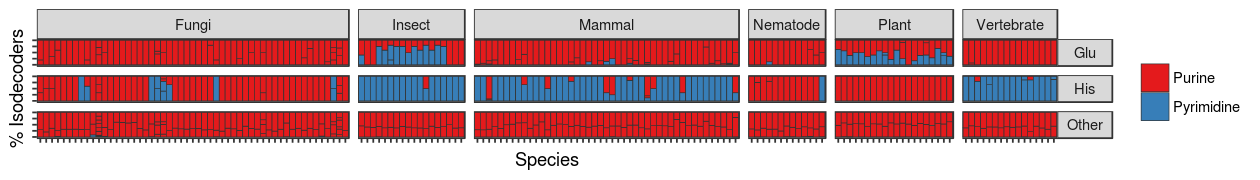

In [69]:
options(repr.plot.width=10.5, repr.plot.height=1.5)
identities %>% filter(!restrict, isotype == "Glu") %>%
  count(isotype, clade, species_long, X9) %>%
  rbind(identities %>% filter(!restrict, isotype == "His") %>% count(isotype, species_long, clade, X9)) %>% 
  rbind(identities %>% filter(!restrict, !(isotype %in% c("Glu", "His"))) %>% 
          count(species_long, clade, X9) %>% 
          mutate(isotype = "Other")) %>% 
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+"),
         purine = ifelse(X9 %in% c("A", "G"), "Purine", "Pyrimidine")) %>%
  group_by(clade, isotype, species_long) %>%
  mutate(n = n/sum(n)) %>%
  droplevels %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = purine), width = 1, color = 'gray20', size = 0.2, stat = 'identity', position = 'stack') +
    facet_grid(isotype ~ clade, scales = "free", space = "free") +
    scale_fill_brewer(palette = 'Set1') + 
    theme(axis.text = element_blank(),
          strip.text.y = element_text(angle = 0),
          legend.title = element_blank()) +
    labs(x = "Species", y = "% Isodecoders")

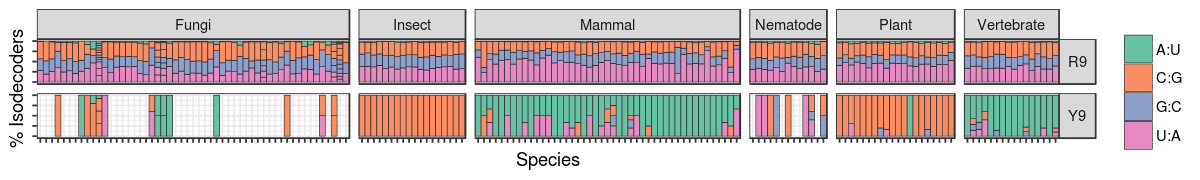

In [70]:
options(repr.plot.width=10, repr.plot.height=1.5)
identities %>% filter(!restrict) %>%
  filter(X12.23 %in% c("U:A", "G:C", "C:G", "A:U")) %>%
  mutate(purine = ifelse(X9 %in% c("A", "G"), "R9", ifelse(X9 != "-", "Y9", "-9"))) %>%
#   mutate(purine = relevel(as.factor(ifelse(X9 %in% c("A", "G"), "R9", paste0(X9, "9"))), "R9")) %>%
  filter(purine != "-9") %>%
  count(clade, species_long, purine, X12.23) %>%
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  group_by(clade, purine, species_long) %>%
  mutate(n = n / sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X12.23), width = 1, color = 'gray20', size = 0.2, stat = 'identity') + 
    facet_grid(purine ~ clade, scales = "free", space = "free") +
    scale_fill_brewer(palette = 'Set2') + 
    theme(axis.text = element_blank(),
          strip.text.y = element_text(angle = 0),
          legend.title = element_blank()) + 
    labs(x = "Species", y = "% Isodecoders")

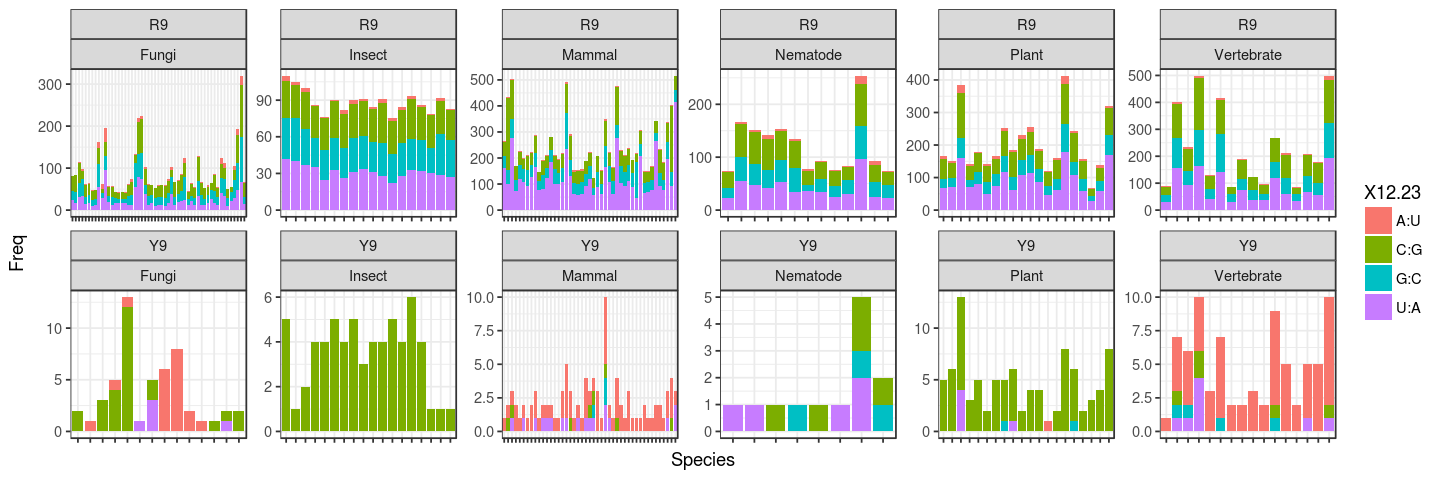

In [71]:
options(repr.plot.width=12, repr.plot.height=4)
identities %>% filter(!restrict) %>%
  filter(X12.23 %in% c("U:A", "G:C", "C:G", "A:U")) %>%
  mutate(purine = ifelse(X9 %in% c("A", "G"), "R9", ifelse(X9 != "-", "Y9", "-9"))) %>%
#   mutate(purine = relevel(as.factor(ifelse(X9 %in% c("A", "G"), "R9", paste0(X9, "9"))), "R9")) %>%
  filter(purine != "-9") %>%
  count(clade, species_long, purine, X12.23) %>%
  ungroup %>%
  mutate(species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  group_by(clade, purine, species_long) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X12.23), stat = 'identity') + 
    facet_wrap(purine ~ clade, scales = "free", nrow = 2) +
    theme(axis.text.x = element_blank()) + 
    labs(x = "Species", y = "Freq")

## Y11:R24

In [75]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X11.24', !(identity %in% c('CG', 'UA', 'PyrimidinePurine')))

,isotype,positions,clade,identity
1,His,X11.24,Fungi,Paired
2,Tyr,X11.24,Fungi,Paired
3,Val,X11.24,Fungi,Paired
4,iMet,X11.24,Fungi,Paired
5,Asp,X11.24,Plant,Paired
6,Met,X11.24,Plant,Paired
7,Asn,X11.24,Vertebrate,Paired


In [82]:
# clade/isotype freqs
best_freqs %>% filter(positions == 'X11.24', !(feature %in% c('CG', 'UA', 'PyrimidinePurine')))

clade_iso_freqs %>% filter((clade == 'Fungi' & isotype == 'Val') |
                           (clade == 'Plant' & isotype == 'Asp') |
                           (clade == 'Plant' & isotype == 'Met') |
                           (clade == 'Vertebrate' & isotype == 'Asn'),
                           positions == 'X11.24', freq > 0.1) %>%
  arrange(isotype, clade, freq)
                           

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Val,X11.24,338,Paired,338,1
2,Plant,Asp,X11.24,143,Paired,143,1
3,Plant,Met,X11.24,120,Paired,120,1
4,Vertebrate,Asn,X11.24,142,Paired,134,0.943661971830986


,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Vertebrate,Asn,X11.24,142,CG,125,0.880281690140845
2,Vertebrate,Asn,X11.24,142,PyrimidinePurine,125,0.880281690140845
3,Vertebrate,Asn,X11.24,142,StrongPair,125,0.880281690140845
4,Vertebrate,Asn,X11.24,142,Paired,134,0.943661971830986
5,Plant,Asp,X11.24,143,UG,21,0.146853146853147
6,Plant,Asp,X11.24,143,Wobble,21,0.146853146853147
7,Plant,Asp,X11.24,143,UA,118,0.825174825174825
8,Plant,Asp,X11.24,143,PyrimidinePurine,118,0.825174825174825
9,Plant,Asp,X11.24,143,WeakPair,118,0.825174825174825
10,Plant,Asp,X11.24,143,Paired,143,1


In [78]:
# species check
identities %>% filter(!restrict) %>% select(clade, species, isotype, X11.24) %>% 
  count(clade, species, isotype, X11.24) %>%
  filter(n != 0) %>% spread(X11.24, n, 0) %>% filter(`C:G` == 0 & `U:A` == 0)

,clade,species,isotype,A:A,A:C,A:G,A:U,C:A,C:C,C:G,C:U,G:A,G:C,G:G,U:A,U:C,U:G,U:U
1,Fungi,aspeFumi_AF293,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Fungi,crypGatt_WM276,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Fungi,crypNeof_VAR_GRUBII_H99,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Fungi,crypNeof_VAR_NEOFORMANS_B_3501,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,Fungi,crypNeof_VAR_NEOFORMANS_JEC21,Tyr,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,Fungi,flamVelu_KACC42780,His,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
7,Fungi,schiPomb_972H,iMet,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## R15:Y48

In [85]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X15.48', !(identity %in% c('GC', 'AU', 'PurinePyrimidine'))) %>% arrange(isotype)

,isotype,positions,clade,identity
1,Ala,X15.48,Insect,NA
2,Ala,X15.48,Mammal,NA
3,Ala,X15.48,Nematode,NA
4,Ala,X15.48,Plant,Mismatched
5,Ala,X15.48,Vertebrate,NA
6,Asn,X15.48,Nematode,NA
7,Asp,X15.48,Fungi,NA
8,Gln,X15.48,Fungi,Paired
9,Glu,X15.48,Fungi,NA
10,Gly,X15.48,Fungi,NA


In [86]:
# check no. species with tRNAs of an isotype without R15:Y48
identities %>% filter(!restrict) %>% count(species, clade, isotype, X15.48) %>% spread(X15.48, n, fill = 0) %>% 
  filter(`G:C` == 0 & `A:U` == 0) %>%
  ungroup %>% group_by(species, clade) %>% summarize(isotype = paste(isotype, collapse = '/')) %>% arrange(clade)

,species,clade,isotype
1,ashbGoss_ATCC10895,Fungi,Glu
2,aspeFumi_AF293,Fungi,Asp
3,aspeNidu_FGSC_A4,Fungi,Asp
4,botrCine_B05_10,Fungi,Asp/Phe
5,candAlbi_WO_1,Fungi,Phe
6,candDubl_CD36,Fungi,Phe
7,candGlab_CBS_138,Fungi,Glu
8,candOrth_CO_90_125,Fungi,Phe
9,crypGatt_WM276,Fungi,Met
10,crypNeof_VAR_GRUBII_H99,Fungi,Met


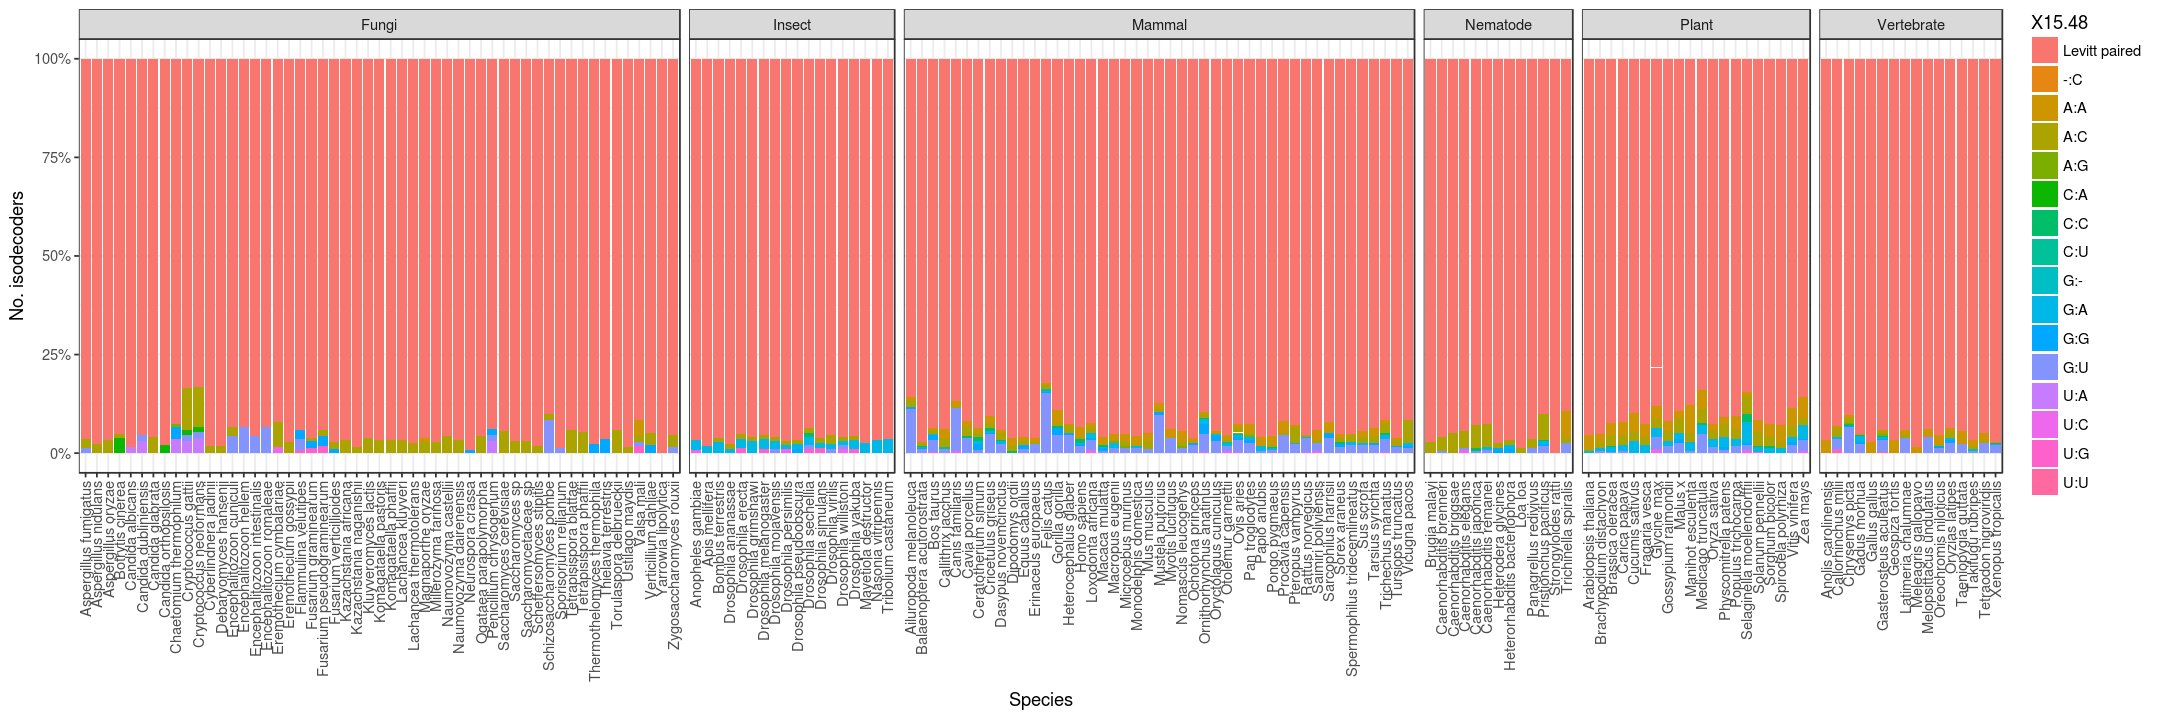

In [87]:
options(repr.plot.width=18, repr.plot.height=6)
identities %>% filter(!restrict) %>% count(clade, species_long, isotype, X15.48) %>% 
  ungroup %>%
  mutate(X15.48 = ifelse(X15.48 %in% c("G:C", "A:U"), "Levitt paired", X15.48),
         species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  mutate(X15.48 = relevel(as.factor(X15.48), "Levitt paired")) %>%
  group_by(species_long, clade) %>% 
  mutate(n = n / sum(n)) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = X15.48), stat = 'identity') +
    facet_grid( ~ clade, scales = "free", space = "free") +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Species", y = "No. isodecoders")

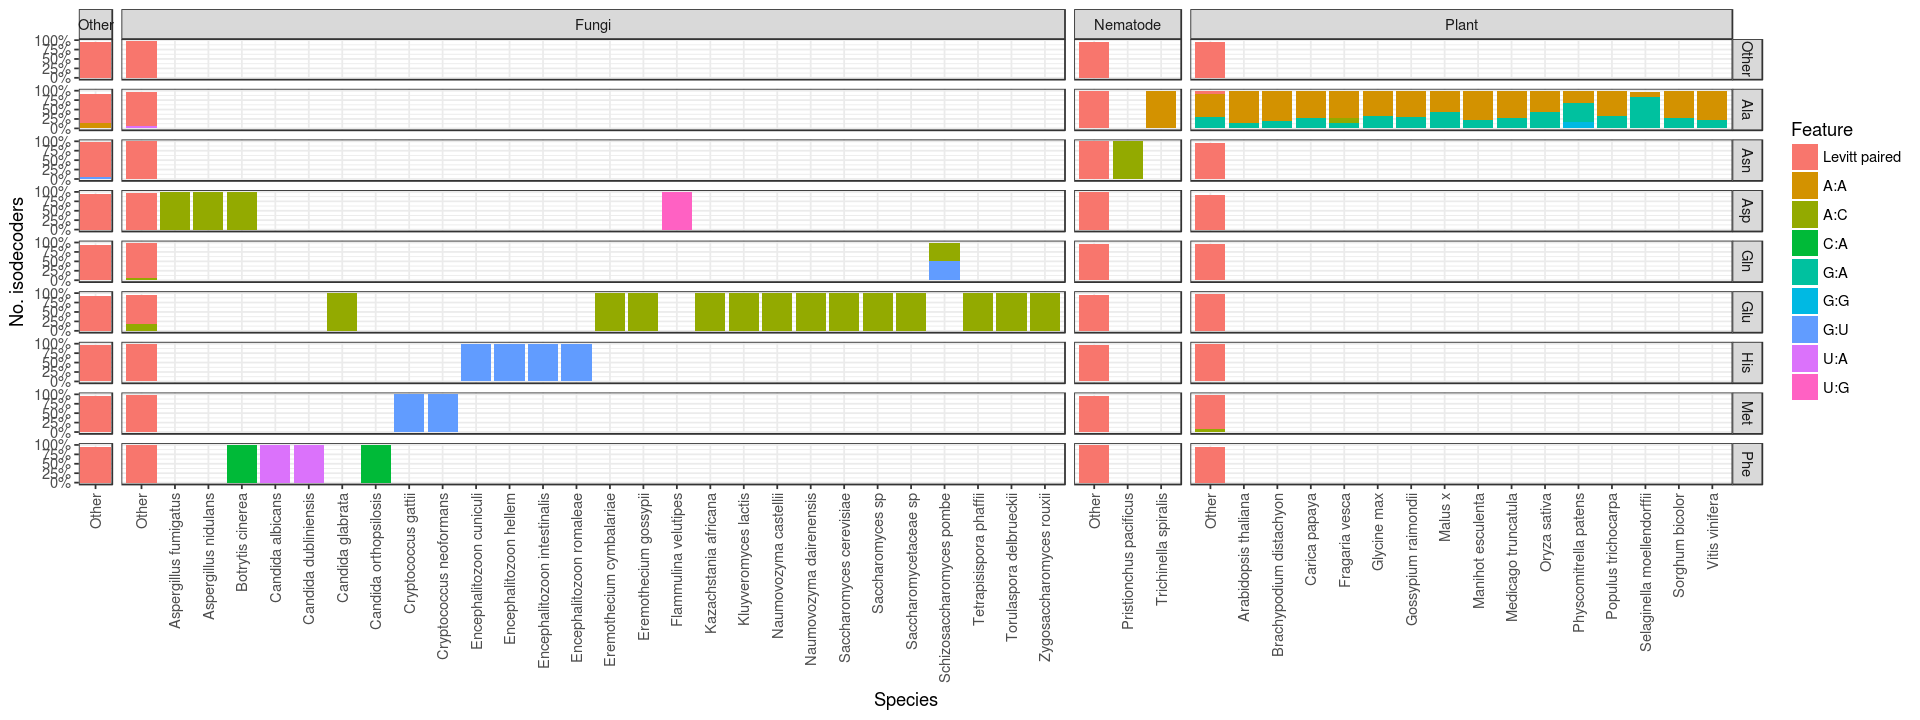

In [88]:
options(repr.plot.width=16, repr.plot.height=6)
identities %>% filter(!restrict) %>% count(clade, species_long, isotype, X15.48) %>% spread(X15.48, n, 0) %>%
  ungroup %>%
  mutate(species_long = relevel(as.factor(ifelse(`G:C` == 0 & `A:U` == 0, str_extract(species_long, "^\\w+ \\w+"), "Other")), "Other"),
         isotype = relevel(as.factor(ifelse(isotype %in% c("Asp", "Phe", "Glu", "Met", "His", "Asn", "Ala", "Gln"), isotype, "Other")), "Other"),
         clade = relevel(as.factor(ifelse(clade %in% c("Fungi", "Nematode", "Plant"), clade, "Other")), "Other")) %>%
  gather(Feature, n, -clade, -species_long, -isotype) %>% 
  mutate(Feature = relevel(as.factor(ifelse(Feature %in% c("G:C", "A:U"), "Levitt paired", Feature)), "Levitt paired")) %>%
  group_by(species_long, clade, Feature, isotype) %>%
  summarize(n = sum(n)) %>%
  group_by(species_long, clade, isotype) %>%
  mutate(n = n / sum(n)) %>% 
  filter(n > 0.05) %>%
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = Feature), stat = 'identity') + 
    facet_grid(isotype ~ clade, space = 'free', scales = 'free') +
    scale_y_continuous(labels = percent_format()) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(x = "Species", y = "No. isodecoders")

## Y16

In [90]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X16', identity != 'C' & identity != 'U') %>% arrange(isotype)

,isotype,positions,clade,identity
1,Ala,X16,Fungi,Keto
2,Ala,X16,Insect,Weak
3,Ala,X16,Mammal,D
4,Ala,X16,Nematode,Keto
5,Ala,X16,Plant,Weak
6,Ala,X16,Vertebrate,H
7,Arg,X16,Insect,H
8,Asn,X16,Fungi,Pyrimidine
9,Asn,X16,Plant,Pyrimidine
10,Asp,X16,Fungi,B


## 18:55

In [92]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X18.55', identity != 'GU')

,isotype,positions,clade,identity
1,Pro,X18.55,Fungi,Paired
2,Met,X18.55,Vertebrate,Paired


In [93]:
# 18:55 fails isotype/species check
identities %>% filter(!restrict) %>% select(clade, species, isotype, X18.55) %>%
  count(clade, species, isotype, X18.55) %>% spread(X18.55, n, 0) %>% filter(`G:U` == 0)

,clade,species,isotype,-:U,A:G,A:U,C:U,G:-,G:A,G:C,G:G,G:U,U:U
1,Fungi,flamVelu_KACC42780,Pro,0,0,2,2,0,0,0,0,0,0


In [96]:
best_freqs %>% filter(clade == 'Vertebrate', isotype == 'Met', positions == 'X18.55') 

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Vertebrate,Met,X18.55,85,Paired,83,0.976470588235294


In [97]:
clade_iso_freqs %>% filter(clade == 'Vertebrate', isotype == 'Met', positions == 'X18.55') %>%
  filter(freq > 0.1) 

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Vertebrate,Met,X18.55,85,GU,75,0.882352941176471
2,Vertebrate,Met,X18.55,85,Paired,83,0.976470588235294
3,Vertebrate,Met,X18.55,85,Wobble,75,0.882352941176471


In [20]:
identities %>% filter(clade == "Fungi", isotype == "Pro") %>%
  count(species_long, X18.55, anticodon, restrict) %>%
  group_by(species_long) %>% mutate(exceptional = any(X18.55[!restrict] != 'G:U')) %>% ungroup %>%
  filter(exceptional) %>%
  group_by(species_long, X18.55, anticodon) %>% summarize(unique = sum(n[!restrict]), total = sum(n)) %>%
  arrange(species_long, anticodon)

,species_long,X18.55,anticodon,unique,total
1,Aspergillus nidulans FGSC A4,G:U,AGG,5,6
2,Aspergillus nidulans FGSC A4,G:U,CGG,1,2
3,Aspergillus nidulans FGSC A4,C:U,TGG,2,2
4,Flammulina velutipes KACC42780,A:U,AGG,1,4
5,Flammulina velutipes KACC42780,A:U,CGG,1,2
6,Flammulina velutipes KACC42780,C:U,TGG,2,4
7,Valsa mali 03-8,G:U,CGG,1,1
8,Valsa mali 03-8,C:U,TGG,2,2
9,Yarrowia lipolytica CLIB122,G:U,AGG,1,21
10,Yarrowia lipolytica CLIB122,G:U,CGG,2,2


## G19:C56

In [98]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X19.56', identity != 'GC')

,isotype,positions,clade,identity


## A21

In [99]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X21', identity != 'A')

,isotype,positions,clade,identity
1,Cys,X21,Fungi,Weak
2,Met,X21,Fungi,Purine
3,Phe,X21,Fungi,H
4,iMet,X21,Fungi,Purine


In [101]:
identities %>% select(clade, species_long, isotype, X8.14.21) %>% 
  count(clade, species_long, isotype, X8.14.21) %>% spread(X8.14.21, n, 0) %>% filter(`U:A:A` == 0) %>%
  gather(`8:14:21`, n, -clade, -species_long, -isotype) %>% filter(n != 0) %>%
  arrange(species_long, isotype)

,clade,species_long,isotype,8:14:21,n
1,Fungi,Aspergillus nidulans FGSC A4,Phe,U:A:U,5
2,Fungi,Penicillium chrysogenum P2niaD18,iMet,U:A:G,1
3,Fungi,Schizosaccharomyces pombe 972h-,Met,U:A:G,3
4,Fungi,Sporisorium reilianum SRZ2,Cys,A:A:U,2
5,Fungi,Sporisorium reilianum SRZ2,Phe,U:A:C,4
6,Fungi,Ustilago maydis 521,Cys,A:A:U,2
7,Fungi,Ustilago maydis 521,Phe,U:A:C,3


## U33

In [102]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X33', identity != 'U')

,isotype,positions,clade,identity
1,iMet,X33,Fungi,Pyrimidine
2,iMet,X33,Insect,C
3,iMet,X33,Mammal,C
4,iMet,X33,Nematode,C
5,iMet,X33,Plant,C
6,iMet,X33,Vertebrate,C


In [104]:
# No. species with only C33, no. species with only U33, and no. species with both
identities %>% filter(!restrict) %>% select(clade, species, isotype, X33) %>% 
  filter(isotype == "iMet") %>%
  count(clade, species, isotype, X33) %>% spread(X33, n, 0) %>% 
  group_by(clade) %>% summarize(Cs = sum(C > 0 & U == 0), Us = sum(U > 0 & C == 0), CUs = sum(U > 0 & C > 0))

# which fungi is it
identities %>% filter(!restrict, clade == "Fungi", isotype == 'iMet') %>% select(species, X33) %>%
  count(species, X33) %>% spread(X33, n, 0) %>% filter(U == 0)

,clade,Cs,Us,CUs
1,Fungi,1,60,0
2,Insect,18,0,0
3,Mammal,43,0,2
4,Nematode,12,0,1
5,Plant,20,0,0
6,Vertebrate,14,0,2


,species,C,U
1,flamVelu_KACC42780,1,0


## R46

In [108]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X46', !(identity %in% c('A', 'G', 'Purine')))

,isotype,positions,clade,identity
1,Leu,X46,Fungi,Keto
2,Ser,X46,Plant,NA


In [114]:
# clade/isotype freqs
best_freqs %>% filter(positions == "X46", isotype %in% c('Leu', 'Ser')) %>% 
  filter(freq > 0.1) %>%
  arrange(isotype, freq)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Nematode,Leu,X46,152,G,137,0.901315789473684
2,Mammal,Leu,X46,806,G,751,0.931761786600496
3,Fungi,Leu,X46,459,Keto,434,0.945533769063181
4,Vertebrate,Leu,X46,409,Purine,388,0.948655256723716
5,Plant,Leu,X46,357,G,349,0.977591036414566
6,Insect,Leu,X46,159,G,159,1
7,Fungi,Ser,X46,402,G,363,0.902985074626866
8,Mammal,Ser,X46,802,G,736,0.917705735660848
9,Vertebrate,Ser,X46,368,G,346,0.940217391304348
10,Nematode,Ser,X46,154,G,150,0.974025974025974


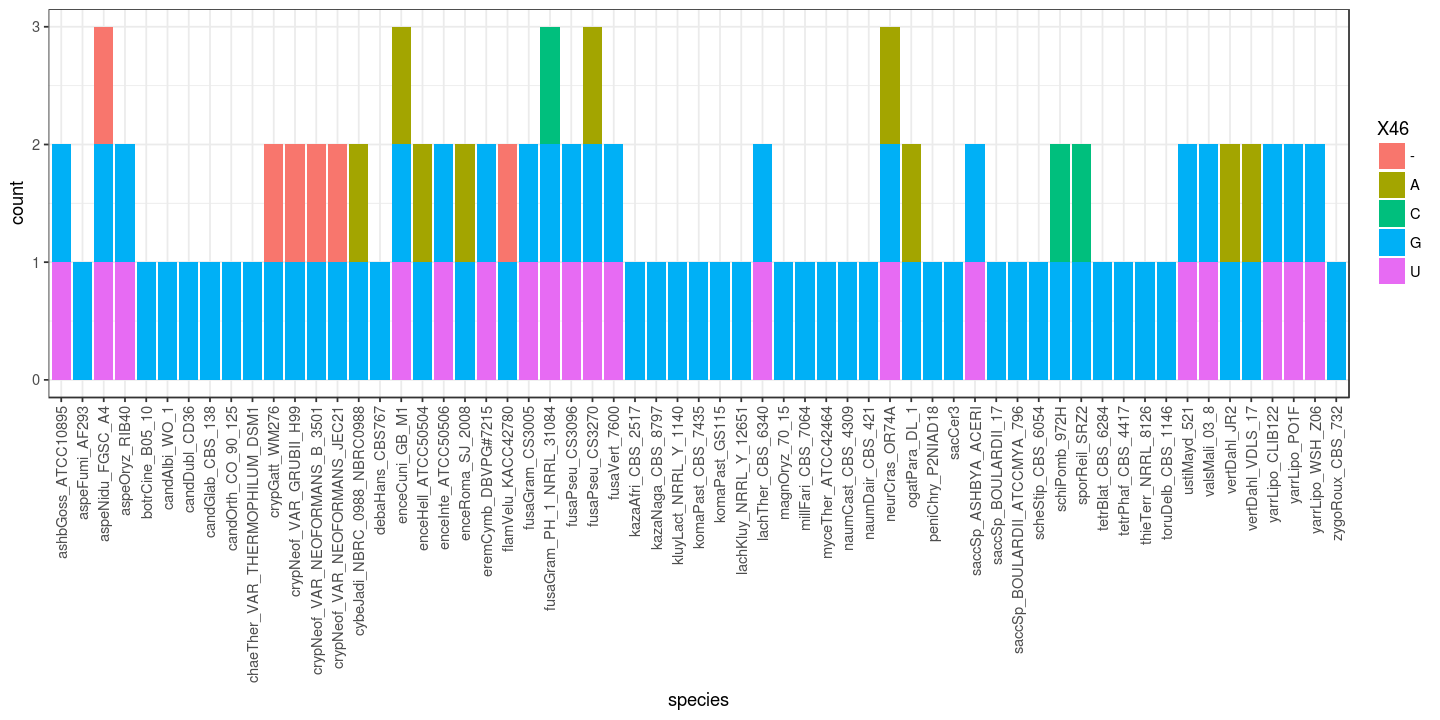

In [36]:
# what does the distribution of fungal Leu look like at 46?
options(repr.plot.width=12, repr.plot.height=6)
identities %>% filter(!restrict, isotype == 'Leu', clade == 'Fungi') %>% 
  count(species, X46) %>%
  ggplot() + geom_bar(aes(x = species, fill = X46)) + theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

In [121]:
clade_iso_freqs %>% filter(clade == 'Plant', isotype == 'Ser', positions == 'X46') %>%
  filter(freq > 0.1)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Plant,Ser,X46,357,G,308,0.862745098039216
2,Plant,Ser,X46,357,Absent,39,0.109243697478992
3,Plant,Ser,X46,357,Purine,308,0.862745098039216
4,Plant,Ser,X46,357,Strong,308,0.862745098039216
5,Plant,Ser,X46,357,Keto,308,0.862745098039216
6,Plant,Ser,X46,357,B,308,0.862745098039216
7,Plant,Ser,X46,357,D,308,0.862745098039216
8,Plant,Ser,X46,357,V,308,0.862745098039216


In [117]:
# species check for plant Ser
identities %>% filter(!restrict, clade == 'Plant', isotype == 'Ser') %>% 
  count(species_long, isotype, X46) %>% spread(X46, n, 0)

,species_long,isotype,-,A,C,G,U
1,Arabidopsis thaliana (TAIR10 Feb 2011),Ser,2,0,0,21,0
2,Brachypodium distachyon Bd21 (JGI v3.0),Ser,5,1,0,6,0
3,Brassica oleracea var. oleracea TO1000,Ser,0,0,0,36,0
4,Carica papaya (papaya),Ser,1,0,1,9,0
5,Cucumis sativus (cucumber),Ser,0,0,0,8,0
6,Fragaria vesca (strawberry) (v2.0.a1),Ser,1,0,0,9,0
7,Glycine max (soybean) (Wm82.a2),Ser,2,0,0,12,0
8,Gossypium raimondii (Cotton v2),Ser,0,0,0,30,0
9,Malus x domestica (apple v3.0.a1),Ser,0,0,1,25,0
10,Manihot esculenta (Cassava v6),Ser,1,0,0,17,0


## Y48

In [147]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X48', !(identity %in% c('C', 'U', 'Pyrimidine')))

,isotype,positions,clade,identity
1,Asp,X48,Fungi,B
2,Phe,X48,Fungi,Amino
3,Ala,X48,Insect,Amino
4,Ala,X48,Mammal,Amino
5,Ala,X48,Nematode,Amino
6,Ala,X48,Plant,A
7,Ala,X48,Vertebrate,Amino


In [137]:
# clade/isotype freqs
best_freqs %>% filter(positions == "X48", isotype == 'Ala')

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Plant,Ala,X48,237,A,227,0.957805907172996
2,Nematode,Ala,X48,97,C,91,0.938144329896907
3,Fungi,Ala,X48,300,C,271,0.903333333333333
4,Vertebrate,Ala,X48,220,Amino,218,0.990909090909091
5,Insect,Ala,X48,97,Amino,96,0.989690721649485
6,Mammal,Ala,X48,1046,Amino,1003,0.958891013384321


In [140]:
clade_iso_freqs %>% filter(positions == 'X48', isotype == 'Asp', clade == 'Fungi') %>%
  filter(freq > 0.1)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Asp,X48,108,C,79,0.731481481481482
2,Fungi,Asp,X48,108,U,28,0.259259259259259
3,Fungi,Asp,X48,108,Pyrimidine,107,0.990740740740741
4,Fungi,Asp,X48,108,Weak,28,0.259259259259259
5,Fungi,Asp,X48,108,Strong,79,0.731481481481482
6,Fungi,Asp,X48,108,Amino,79,0.731481481481482
7,Fungi,Asp,X48,108,Keto,28,0.259259259259259
8,Fungi,Asp,X48,108,B,107,0.990740740740741
9,Fungi,Asp,X48,108,D,28,0.259259259259259
10,Fungi,Asp,X48,108,H,107,0.990740740740741


In [145]:
# why does Pyrimidine not qualify for fungal Asp?
identities %>% filter(isotype == 'Asp', clade == 'Fungi') %>%
  count(species_long, X48) %>% spread(X48, n, 0) %>%
  filter(`C` == 0 & `U` == 0)

,species_long,C,G,U
1,Flammulina velutipes KACC42780,0,11,0


In [143]:
clade_iso_freqs %>% filter(positions == 'X48', isotype == 'Phe', clade == 'Fungi') %>%
  filter(freq > 0.1)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Phe,X48,148,C,138,0.932432432432432
2,Fungi,Phe,X48,148,Pyrimidine,138,0.932432432432432
3,Fungi,Phe,X48,148,Strong,138,0.932432432432432
4,Fungi,Phe,X48,148,Amino,146,0.986486486486487
5,Fungi,Phe,X48,148,B,138,0.932432432432432
6,Fungi,Phe,X48,148,H,146,0.986486486486487
7,Fungi,Phe,X48,148,V,146,0.986486486486487


In [146]:
# why does Pyrimidine not qualify for fungal Phe?
identities %>% filter(isotype == 'Phe', clade == 'Fungi') %>%
  count(species_long, X48) %>% spread(X48, n, 0) %>%
  filter(`C` == 0 & `U` == 0)

,species_long,A,C,U
1,Botrytis cinerea B05.10,7,0,0
2,Candida albicans WO-1,5,0,0
3,Candida dubliniensis CD36,5,0,0
4,Candida orthopsilosis Co 90-125,1,0,0


## R52:Y62

In [149]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X52.62', !(identity %in% c('GC', 'AU', 'PurinePyrimidine'))) %>%
  arrange(isotype)

,isotype,positions,clade,identity
1,Ala,X52.62,Fungi,Paired
2,Cys,X52.62,Fungi,Paired
3,Glu,X52.62,Mammal,Paired
4,Gly,X52.62,Fungi,Paired
5,His,X52.62,Fungi,NA
6,Met,X52.62,Fungi,NA
7,Phe,X52.62,Fungi,Paired
8,Phe,X52.62,Mammal,Paired
9,Phe,X52.62,Plant,Paired
10,Pro,X52.62,Fungi,StrongPair


## G53:C61

In [150]:
# clade/isotype check
clade_isotype_specific %>% filter(positions == 'X53.61', identity != 'GC')

,isotype,positions,clade,identity
1,Pro,X53.61,Nematode,Paired


In [151]:
clade_iso_freqs %>% filter(positions == "X53.61", isotype == "Pro", clade == "Nematode", freq > 0.02)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Nematode,Pro,X53.61,88,GC,76,0.863636363636364
2,Nematode,Pro,X53.61,88,UA,10,0.113636363636364
3,Nematode,Pro,X53.61,88,Paired,87,0.988636363636364
4,Nematode,Pro,X53.61,88,PurinePyrimidine,76,0.863636363636364
5,Nematode,Pro,X53.61,88,PyrimidinePurine,10,0.113636363636364
6,Nematode,Pro,X53.61,88,StrongPair,76,0.863636363636364
7,Nematode,Pro,X53.61,88,WeakPair,10,0.113636363636364


## U54:A58

In [154]:
clade_isotype_specific %>% filter(positions == 'X54.58', identity != 'UA') %>%
  arrange(isotype)

,isotype,positions,clade,identity
1,Ala,X54.58,Insect,NA
2,Ala,X54.58,Mammal,NA
3,Ala,X54.58,Nematode,NA
4,Ala,X54.58,Plant,NA
5,Ala,X54.58,Vertebrate,NA
6,His,X54.58,Plant,Mismatched
7,Ile,X54.58,Mammal,NA
8,Lys,X54.58,Insect,Paired
9,Lys,X54.58,Mammal,NA
10,Pro,X54.58,Nematode,NA


In [155]:
# iMets in general have what kind of mismatch?
identities %>% filter(!restrict, isotype == "iMet") %>%
  count(clade, X54.58) %>% spread(X54.58, n, 0)

,clade,A:A,C:A,U:A
1,Fungi,91,0,4
2,Insect,32,0,0
3,Mammal,88,0,0
4,Nematode,18,0,0
5,Plant,54,0,0
6,Vertebrate,65,1,2


In [157]:
clade_iso_freqs %>% filter(positions == "X54.58", isotype == 'Ala') %>% 
  filter(freq > 0.1) %>% arrange(clade)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Fungi,Ala,X54.58,300,UA,300,1
2,Fungi,Ala,X54.58,300,Paired,300,1
3,Fungi,Ala,X54.58,300,PyrimidinePurine,300,1
4,Fungi,Ala,X54.58,300,WeakPair,300,1
5,Insect,Ala,X54.58,97,UA,62,0.639175257731959
6,Insect,Ala,X54.58,97,Paired,62,0.639175257731959
7,Insect,Ala,X54.58,97,Mismatched,35,0.360824742268041
8,Insect,Ala,X54.58,97,PyrimidinePurine,62,0.639175257731959
9,Insect,Ala,X54.58,97,WeakPair,62,0.639175257731959
10,Mammal,Ala,X54.58,1046,UA,819,0.782982791586998


In [167]:
clade_iso_freqs %>% filter((isotype == 'His' & clade == 'Plant') |
                           (isotype == 'Ile' & clade == 'Mammal') |
                           (isotype == 'Lys' & clade %in% c('Mammal', 'Insect')) |
                           (isotype == 'Pro' & clade == 'Nematode') |
                           (isotype == 'Tyr' & clade == 'Fungi')) %>%
  filter(positions == 'X54.58', freq > 0.1) %>% arrange(isotype, clade, desc(freq))

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Plant,His,X54.58,45,Mismatched,42,0.933333333333333
2,Mammal,Ile,X54.58,511,Paired,458,0.896281800391389
3,Mammal,Ile,X54.58,511,UA,456,0.892367906066536
4,Mammal,Ile,X54.58,511,PyrimidinePurine,456,0.892367906066536
5,Mammal,Ile,X54.58,511,WeakPair,456,0.892367906066536
6,Mammal,Ile,X54.58,511,Mismatched,53,0.103718199608611
7,Insect,Lys,X54.58,71,Paired,68,0.957746478873239
8,Insect,Lys,X54.58,71,UA,62,0.873239436619718
9,Insect,Lys,X54.58,71,PyrimidinePurine,62,0.873239436619718
10,Insect,Lys,X54.58,71,WeakPair,62,0.873239436619718


## R57

In [171]:
# clade / isotype check
clade_isotype_specific %>% filter(positions == 'X57', !(identity %in% c('A', 'G', 'Purine'))) %>%
  arrange(isotype, clade)

,isotype,positions,clade,identity


## Y60

In [170]:
# clade / isotype check
clade_isotype_specific %>% filter(positions == 'X60', !(identity %in% c('C', 'U', 'Pyrimidine'))) %>%
  arrange(isotype, clade)

,isotype,positions,clade,identity
1,Ala,X60,Insect,NA
2,Ala,X60,Mammal,B
3,Ala,X60,Nematode,H
4,Ala,X60,Plant,H
5,Ala,X60,Vertebrate,Strong
6,Ile,X60,Plant,Amino
7,Met,X60,Fungi,B
8,Val,X60,Mammal,Amino
9,Val,X60,Vertebrate,Amino
10,iMet,X60,Fungi,Weak


In [183]:
clade_iso_freqs %>% filter((isotype == 'Ile' & clade == 'Plant') |
                           (isotype == 'Met' & clade == 'Fungi') |
                           (isotype == 'Val' & clade %in% c('Vertebrate', 'Mammal'))) %>%
  filter(positions == "X60", freq > 0.1) %>% arrange(isotype, clade)

,clade,isotype,positions,clade_iso_pos_total,feature,n,freq
1,Plant,Ile,X60,224,A,145,0.647321428571429
2,Plant,Ile,X60,224,C,69,0.308035714285714
3,Plant,Ile,X60,224,Purine,145,0.647321428571429
4,Plant,Ile,X60,224,Pyrimidine,69,0.308035714285714
5,Plant,Ile,X60,224,Weak,145,0.647321428571429
6,Plant,Ile,X60,224,Strong,69,0.308035714285714
7,Plant,Ile,X60,224,Amino,214,0.955357142857143
8,Plant,Ile,X60,224,B,69,0.308035714285714
9,Plant,Ile,X60,224,D,145,0.647321428571429
10,Plant,Ile,X60,224,H,214,0.955357142857143


In [185]:
identities %>% filter(clade == 'Fungi', isotype == 'Met') %>%
  count(species_long, X60) %>% spread(X60, n, 0) %>% filter(C == 0 & U == 0)

,species_long,A,C,G,U
1,Magnaporthe oryzae 70-15,0,0,4,0


# Misc sequence features

## Exceptions to 8:14:21 in fungi

In [187]:
identities %>% filter(clade == 'Fungi') %>%
  count(species_long, X8.14.21, isotype) %>% spread(X8.14.21, n, 0) %>%
  filter(`U:A:A` == 0)

,species_long,isotype,-:A:A,A:A:U,U:A:A,U:A:C,U:A:G,U:A:U,U:G:A
1,Aspergillus nidulans FGSC A4,Phe,0,0,0,0,0,5,0
2,Penicillium chrysogenum P2niaD18,iMet,0,0,0,0,1,0,0
3,Schizosaccharomyces pombe 972h-,Met,0,0,0,0,3,0,0
4,Sporisorium reilianum SRZ2,Cys,0,2,0,0,0,0,0
5,Sporisorium reilianum SRZ2,Phe,0,0,0,4,0,0,0
6,Ustilago maydis 521,Cys,0,2,0,0,0,0,0
7,Ustilago maydis 521,Phe,0,0,0,3,0,0,0


## 3D interaction freqs

In [ ]:
# 9:23
identities %>% select(restrict, clade, species_long, isotype, X9.23) %>% filter(!restrict) %>%
  group_by(clade, X9.23) %>% tally %>% spread(X9.23, n, fill='.')

# 10:45
identities %>% select(restrict, clade, species_long, isotype, X10.45) %>% filter(!restrict) %>%
  group_by(clade, X10.45) %>% tally %>% spread(X10.45, n, fill='.')

# 22:46
identities %>% select(restrict, clade, species_long, isotype, X22.46) %>% filter(!restrict) %>%
  group_by(clade, X22.46) %>% tally %>% spread(X22.46, n, fill='.')

## Base pair mismatches

In [ ]:
# 3:70 in mammals
identities %>% filter(!restrict) %>%
  select(clade, species, isotype, X3.70) %>% filter(clade == "Mammal", isotype == "Gln") %>% 
  group_by(species, X3.70) %>% tally %>% spread(X3.70, n, 0)

In [ ]:
# 3:70 in vertebrates
identities %>% filter(!restrict) %>%
  select(clade, species_long, isotype, X3.70) %>% filter(clade == "Vertebrate", isotype == "Gln") %>% 
  group_by(species_long, X3.70) %>% tally %>% spread(X3.70, n, 0)

In [ ]:
df = identities %>% select(clade, species, isotype, X1.72) %>% filter(clade == "Vertebrate", isotype == "Ala") %>% group_by(X1.72) %>% tally

## 13:22

In [ ]:
identities %>% filter(isotype %in% c("Leu", "Ser", "Val", "Pro")) %>% select(clade, species, isotype, X13.22) %>%
  group_by(clade, isotype, X13.22) %>% tally %>% spread(X13.22, n, 0)

In [ ]:
identities %>% count(isotype, clade) %>% 
  filter(isotype %in% c("Leu", "Ser", "Val", "Pro")) %>% 
  spread(isotype, n, 0)

In [ ]:
options(repr.plot.width=7, repr.plot.height=4)
identities %>% filter(!restrict) %>%
  mutate(mismatch = ifelse(X13.22 %in% c("A:U", "U:A", "U:G", "G:U", "C:G", "G:C"), "Paired", "Mismatch"),
         clade = ifelse(clade == "Fungi", "Fungi", "Other")) %>%
  count(isotype, clade, mismatch) %>%
  group_by(isotype, clade) %>%
  mutate(n = n / sum(n)) %>% 
  ggplot() + geom_bar(aes(x = isotype, y = n, fill = mismatch), stat = 'identity', position = 'stack') +
    facet_wrap(~ clade, scales = 'free', ncol = 1)
#     scale_y_continuous(labels = percent_format())

In [ ]:
options(repr.plot.width=12, repr.plot.height=4)
identities %>% filter(!restrict) %>%
  mutate(mismatch = ifelse(X13.22 %in% c("A:U", "U:A", "U:G", "G:U", "C:G", "G:C"), "Paired", "Mismatch"),
         clade = ifelse(clade == "Fungi", "Fungi", "Other"),
         isotype = ifelse(!(isotype %in% c("Pro", "Val", "Leu", "Ser")), "Other", isotype),
         species_long = str_extract(species_long, "^\\w+ \\w+")) %>%
  mutate(isotype = factor(isotype, levels = c("Leu", "Ser", "Pro", "Val", "Other"))) %>%
  count(isotype, clade, species_long, mismatch) %>%
  group_by(isotype, clade, species_long) %>%
  mutate(n = n / sum(n)) %>% 
  ggplot() + geom_bar(aes(x = species_long, y = n, fill = mismatch), stat = 'identity', position = 'stack') +
    facet_grid(isotype ~ clade, scale = "free", space = "free") + 
    theme(axis.text.x = element_blank()) + 
    labs(x = "Species", y = "Percentage of isodecoders")

## 12:23 in Gly

In [ ]:
identities %>% filter(!restrict, isotype == "Gly") %>% select(clade, species, isotype, X12.23) %>%
  group_by(clade, species, isotype, X12.23) %>% tally %>% spread(X12.23, n, 0) %>% filter(`A:A` != 0 | `C:A` != 0 | `A:C` != 0 | `G:A` != 0 | `U:C` != 0)

## 27:43 in Phe

In [ ]:
identities %>% filter(isotype == "Phe", clade %in% c("Fungi", "Nematode")) %>% select(clade, species, isotype, X27.43) %>%
  group_by(clade, species, isotype, X27.43) %>% tally %>% spread(X27.43, n, 0) %>% filter(`A:G` != 0 | `C:A` != 0 | `G:A` != 0 | `U:U` != 0)

## 50:64 in Ile

In [ ]:
identities %>% filter(isotype == "Ile", clade == "Insect") %>% select(clade, species, isotype, X50.64) %>%
  group_by(clade, species, isotype, X50.64) %>% tally %>% spread(X50.64, n, 0)

In [ ]:
identities %>% filter(!restrict, species == "micMur1", isotype == "Ser")  %>% select(species, seqname, score, isotype, isoscore_ac, X5.68, X6.67, X7.66)

In [ ]:
identities %>% filter(!restrict, clade == "Mammal", isotype == "Ser") %>% select(species, X5.68, X6.67, X7.66) %>%
  gather(position, feature, -species) %>% group_by(feature) %>% tally %>% spread(feature, n, 0)

identities %>% filter(!restrict, clade == "Mammal", isotype == "Ser") %>% select(species, X5.68, X6.67, X7.66) %>%
  gather(position, feature, -species) %>% group_by(species, feature) %>% tally %>% spread(feature, n, 0)

In [ ]:
# Are tRNAs with introns enriched for mismatches at 32:38?
identities %>% filter(!restrict) %>%
  mutate(intron = intron > 6, mismatch = paste0(X32, ':', X38) %in% c('U:U', 'U:C', 'C:C')) %>%
  count(intron, mismatch) %>% mutate(freq = n / sum(n))

In [ ]:
options(repr.plot.width=10, repr.plot.height=2)
# 6:67 mismatches in fungal alanine
identities %>% filter(!restrict, clade == "Fungi", isotype == 'Ala') %>% 
  count(X6.67, species_long, isotype, clade) %>% 
  spread(X6.67, n, 0) %>%
  mutate(position = '6:67') %>%
  full_join(identities %>% filter(!restrict, clade == "Mammal", isotype == "Gln") %>% 
              count(X3.70, species_long, isotype, clade) %>%
              spread(X3.70, n, 0) %>%
              mutate(position = '3:70')) %>%
  full_join(identities %>% filter(!restrict, clade == "Insect", isotype == "Ile") %>% 
              count(X50.64, species_long, isotype, clade) %>%
              spread(X50.64, n, 0) %>%
              mutate(position = '50:64', clade = 'Insect')) %>%
#   full_join(identities %>% filter(!restrict, isotype == "Gly") %>% 
#               count(X12.23, species_long, isotype) %>%
#               spread(X12.23, n, 0) %>%
#               mutate(position = '12:23', clade = 'All')) %>%
  replace(is.na(.), 0) %>%
  gather(feature, n, -species_long, -isotype, -clade, -position) %>%
  mutate(mismatch = !(feature %in% c('A:U', 'C:G', 'G:C', 'G:U', 'U:A', 'U:G'))) %>%
  group_by(species_long, isotype, clade, position) %>% summarize(paired = sum(ifelse(mismatch, 0, n)), mismatch = -sum(ifelse(mismatch, n, 0))) %>%
  gather(matchcol, value, paired, mismatch) %>%
  ggplot() + geom_bar(aes(x = str_extract(species_long, "^\\w+ \\w+"), y = value, fill = matchcol), stat = 'identity') + 
    facet_grid(~ paste(clade, isotype, position), scales = 'free', space = 'free') + 
    theme(axis.text.x = element_blank()) + 
    labs(x = "Species", y = "No. isodecoders")

# Fungi of interest

## Overall fungi diversity

In [209]:
# Fungi break the most universal rules?
identities %>% filter(!restrict) %>% rowwise() %>%
  mutate(matches = 18 - sum(c(X8.14 == 'U:A', X9 %in% c("A", "G"), X11.24 %in% c('C:G', 'U:A'), X15.48 %in% c('G:C', 'A:U'), X16 %in% c('C', 'U'),
         X18.55 == 'G:U', X19.56 == 'G:C', X21 == 'A', X32 %in% c('C', 'U'), X33 %in% c('C', 'U'), X37 %in% c('A', 'G'), X46 %in% c('A', 'G'),
         X48 %in% c('C', 'U'), X52.62 %in% c('G:C', 'A:U'), X53.61 == 'G:C', X54.58 == 'U:A', X57 %in% c('A', 'G'), X60 %in% c('C', 'U')))) %>%
  group_by(clade) %>% mutate(ntRNAs = n()) %>% ungroup %>%
  group_by(clade, matches) %>% summarize(n = n(), ntRNAs = ntRNAs[1]) %>% mutate(n = round(n/ntRNAs, digits = 3)) %>% spread(matches, n, 0)

Warning message:
"Grouping rowwise data frame strips rowwise nature"

,clade,ntRNAs,0,1,2,3,4,5,6
1,Fungi,4804,0.685,0.251,0.053,0.01,0.001,0,0
2,Insect,1664,0.751,0.189,0.036,0.002,0.001,0.021,0
3,Mammal,11627,0.642,0.258,0.067,0.015,0.001,0.016,0
4,Nematode,1601,0.731,0.223,0.038,0.004,0.001,0.002,0
5,Plant,4282,0.646,0.238,0.07,0.018,0.007,0.021,0.001
6,Vertebrate,3984,0.612,0.291,0.073,0.011,0.003,0.011,0


In [210]:
# Fungi are different in many ways... including G15 and X47
identities %>% filter(!restrict, isotype == "Phe", clade == "Fungi") %>%
  count(species, X15) %>% spread(X15, n, 0) %>% filter(G == 0)
identities %>% filter(!restrict, isotype %in% c("Gly", "His"), clade == "Fungi") %>%
  count(species, isotype, X47) %>% spread(X47, n, 0) %>% filter(`-` == 0)

,species,A,C,G,U
1,botrCine_B05_10,0,4,0,0
2,candAlbi_WO_1,0,0,0,1
3,candDubl_CD36,0,0,0,2
4,candOrth_CO_90_125,0,1,0,0


,species,isotype,-,C,U
1,candOrth_CO_90_125,Gly,0,2,0
2,flamVelu_KACC42780,His,0,3,0
3,yarrLipo_CLIB122,Gly,0,4,0
4,yarrLipo_PO1F,Gly,0,5,0
5,yarrLipo_WSH_Z06,Gly,0,4,0


## _Saccharomyces cerevisiae_

In [211]:
identities %>% filter(species == 'sacCer3') %>%
  rowwise %>%
  mutate(X8.14 = (X8.14 == 'U:A'), X9 = (X9 %in% c("A", "G")), X11.24 = (X11.24 %in% c('C:G', 'U:A')), X15.48 = (X15.48 %in% c('G:C', 'A:U')), X16 = (X16 %in% c('C', 'U')), X18.55 = (X18.55 == 'G:U'), X19.56 = (X19.56 == 'G:C'), X21 = (X21 == 'A'), X32 = (X32 %in% c('C', 'U')), X33 = (X33 %in% c('C', 'U')), X37 = (X37 %in% c('A', 'G')), X46 = (X46 %in% c('A', 'G')), X48 = (X48 %in% c('C', 'U')), X52.62 = (X52.62 %in% c('G:C', 'A:U')), X53.61 = (X53.61 == 'G:C'), X54.58 = (X54.58 == 'U:A'), X57 = (X57 %in% c('A', 'G')), X60 = (X60 %in% c('C', 'U'))) %>%
  select(seqname, isotype, score, X8.14, X9, X11.24, X15.48, X16, X18.55, X19.56, X21, X32, X33, X37, X46, X48, X52.62, X53.61, X54.58, X57, X60) %>%
  group_by(isotype) %>%
  summarize(X8.14 = all(X8.14), X9 = all(X9), X11.24 = all(X11.24), X15.48 = all(X15.48), X16 = all(X16), X18.55 = all(X18.55), X19.56 = all(X19.56), X21 = all(X21), X32 = all(X32), X33 = all(X33), X37 = all(X37), X46 = all(X46), X48 = all(X48), X52.62 = all(X52.62), X53.61 = all(X53.61), X54.58 = all(X54.58), X57 = all(X57), X60 = all(X60)) %>%
  rowwise %>%
  filter(any(!c(X8.14, X9, X11.24, X15.48, X16, X18.55, X19.56, X21, X32, X33, X37, X46, X48, X52.62, X53.61, X54.58, X57, X60))) %>%
  gather(position, status, -isotype) %>%
  mutate(status = ifelse(status, '.', 'X')) %>%
  spread(position, status)

Warning message:
"Grouping rowwise data frame strips rowwise nature"

,isotype,X11.24,X15.48,X16,X18.55,X19.56,X21,X32,X33,X37,X46,X48,X52.62,X53.61,X54.58,X57,X60,X8.14,X9
1,Gln,.,.,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.
2,Glu,.,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,Gly,.,.,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.
4,His,.,.,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.
5,Phe,.,.,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.
6,Pro,.,.,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
7,Tyr,.,.,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.
8,Val,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
9,iMet,.,.,.,.,.,.,.,.,.,.,.,.,.,X,.,X,.,.


In [212]:
identities %>% filter(species == 'sacCer3', isotype == 'Gln') %>% count(X54.58)

,X54.58,n
1,U:A,10


## Encephalitozoon

In [207]:
identities %>% filter(str_detect(species, 'ence')) %>%
  rowwise %>%
  mutate(X8.14 = (X8.14 == 'U:A'), X9 = (X9 %in% c("A", "G")), X11.24 = (X11.24 %in% c('C:G', 'U:A')), X15.48 = (X15.48 %in% c('G:C', 'A:U')), X16 = (X16 %in% c('C', 'U')), X18.55 = (X18.55 == 'G:U'), X19.56 = (X19.56 == 'G:C'), X21 = (X21 == 'A'), X32 = (X32 %in% c('C', 'U')), X33 = (X33 %in% c('C', 'U')), X37 = (X37 %in% c('A', 'G')), X46 = (X46 %in% c('A', 'G')), X48 = (X48 %in% c('C', 'U')), X52.62 = (X52.62 %in% c('G:C', 'A:U')), X53.61 = (X53.61 == 'G:C'), X54.58 = (X54.58 == 'U:A'), X57 = (X57 %in% c('A', 'G')), X60 = (X60 %in% c('C', 'U'))) %>%
  select(seqname, isotype, score, X8.14, X9, X11.24, X15.48, X16, X18.55, X19.56, X21, X32, X33, X37, X46, X48, X52.62, X53.61, X54.58, X57, X60) %>%
  group_by(isotype) %>%
  summarize(X8.14 = all(X8.14), X9 = all(X9), X11.24 = all(X11.24), X15.48 = all(X15.48), X16 = all(X16), X18.55 = all(X18.55), X19.56 = all(X19.56), X21 = all(X21), X32 = all(X32), X33 = all(X33), X37 = all(X37), X46 = all(X46), X48 = all(X48), X52.62 = all(X52.62), X53.61 = all(X53.61), X54.58 = all(X54.58), X57 = all(X57), X60 = all(X60)) %>%
  rowwise %>%
  filter(any(!c(X8.14, X9, X11.24, X15.48, X16, X18.55, X19.56, X21, X32, X33, X37, X46, X48, X52.62, X53.61, X54.58, X57, X60))) %>%
  gather(position, status, -isotype) %>%
  mutate(status = ifelse(status, '.', 'X')) %>%
  spread(position, status)

Warning message:
"Grouping rowwise data frame strips rowwise nature"

,isotype,X11.24,X15.48,X16,X18.55,X19.56,X21,X32,X33,X37,X46,X48,X52.62,X53.61,X54.58,X57,X60,X8.14,X9
1,Cys,.,.,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,Glu,.,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,Gly,.,.,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.
4,His,.,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
5,Leu,.,.,.,.,.,.,X,.,.,X,.,.,.,.,.,.,.,.
6,Pro,.,X,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
7,Ser,.,.,.,.,.,.,.,.,.,X,.,.,.,.,.,.,.,.
8,Thr,.,X,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


In [208]:
identities %>% filter(str_detect(species, 'ence'), isotype == 'Cys')

,clade,domain,isotype,seqname,species,species_long,taxid,isotype_best,anticodon,score,⋯,X70i9,X71,X71i1,X71i2,X72,X73,X74,X75,X76,abbrev
1,Fungi,eukaryota,Cys,enceCuni_GB_M1_chrVIII.trna1-CysGCA,enceCuni_GB_M1,Encephalitozoon cuniculi GB-M1,6035,Cys,GCA,66.9,,.,C,.,.,C,U,-,-,-,E. cuniculi
2,Fungi,eukaryota,Cys,enceHell_ATCC50504_chrVIII.trna1-CysGCA,enceHell_ATCC50504,Encephalitozoon hellem ATCC 50504,27973,Cys,GCA,67.3,,.,C,.,.,C,U,-,-,-,E. hellem
3,Fungi,eukaryota,Cys,enceInte_ATCC50506_chrVIII.trna1-CysGCA,enceInte_ATCC50506,Encephalitozoon intestinalis ATCC 50506,571949,Cys,GCA,69.7,,.,C,.,.,C,U,-,-,-,E. intestinalis
4,Fungi,eukaryota,Cys,enceRoma_SJ_2008_chrVIII.trna1-CysGCA,enceRoma_SJ_2008,Encephalitozoon romaleae SJ-2008,571949,Cys,GCA,67.3,,.,C,.,.,C,U,-,-,-,E. romaleae


## Sporisorium reilianum, Ustilago maydis

In [220]:
identities %>% filter(isotype == 'Cys', species %in% c('ustiMayd_521', 'sporReil_SRZ2')) %>%
  count(species, X8.14.21) %>% spread(X8.14.21, n, 0)

,species,A:A:U
1,sporReil_SRZ2,2
2,ustiMayd_521,2


In [219]:
identities %>% filter(isotype == 'Cys', species %in% c('ustiMayd_521', 'sporReil_SRZ2')) %>%
  count(species, X13.22) %>% spread(X13.22, n, 0)

,species,U:U
1,sporReil_SRZ2,2
2,ustiMayd_521,2


## Valsa mali

In [235]:
identities %>% filter(isotype == 'Pro', species == 'valsMali_03_8') %>%
  count(species_long, X18.55)

,species_long,X18.55,n
1,Valsa mali 03-8,C:U,2
2,Valsa mali 03-8,G:U,1


## Candida

In [224]:
identities %>% filter(isotype == 'iMet', str_detect(species, 'cand')) %>%
  count(species_long, X29.41) %>% spread(X29.41, n, 0)

,species_long,A:U,G:C
1,Candida albicans WO-1,2,0
2,Candida dubliniensis CD36,2,0
3,Candida glabrata CBS 138,0,3
4,Candida orthopsilosis Co 90-125,0,2


## Botrytis cinerea

In [233]:
identities %>% filter(isotype == 'Pro', species == 'botrCine_B05_10') %>%
  count(species_long, X13.22)

,species_long,X13.22,n
1,Botrytis cinerea B05.10,C:G,8
2,Botrytis cinerea B05.10,U:U,4


## Cryptococcus

In [226]:
identities %>% filter(isotype == 'iMet', str_detect(species, 'cryp')) %>%
  count(species_long, X29.41)

,species_long,X29.41,n
1,Cryptococcus gattii WM276,A:U,3
2,Cryptococcus neoformans var. grubii H99,A:U,3
3,Cryptococcus neoformans var. neoformans B-3501A,A:U,3
4,Cryptococcus neoformans var. neoformans JEC21,A:U,3


In [227]:
identities %>% filter(isotype == 'Pro', str_detect(species, 'cryp')) %>%
  count(species_long, X13.22)

,species_long,X13.22,n
1,Cryptococcus gattii WM276,C:G,6
2,Cryptococcus gattii WM276,U:G,1
3,Cryptococcus gattii WM276,U:U,1
4,Cryptococcus neoformans var. grubii H99,C:G,6
5,Cryptococcus neoformans var. grubii H99,U:G,1
6,Cryptococcus neoformans var. grubii H99,U:U,1
7,Cryptococcus neoformans var. neoformans B-3501A,C:G,5
8,Cryptococcus neoformans var. neoformans B-3501A,U:G,1
9,Cryptococcus neoformans var. neoformans B-3501A,U:U,1
10,Cryptococcus neoformans var. neoformans JEC21,C:G,5


In [229]:
identities %>% filter(isotype == 'Tyr', str_detect(species, 'cryp')) %>%
  count(species_long, X11.24)

,species_long,X11.24,n
1,Cryptococcus gattii WM276,U:G,4
2,Cryptococcus neoformans var. grubii H99,U:G,4
3,Cryptococcus neoformans var. neoformans B-3501A,U:G,4
4,Cryptococcus neoformans var. neoformans JEC21,U:G,4


## Aspergillus

In [228]:
identities %>% filter(isotype == 'Tyr', str_detect(species, 'aspe')) %>%
  count(species_long, X11.24)

,species_long,X11.24,n
1,Aspergillus fumigatus Af293,U:G,5
2,Aspergillus nidulans FGSC A4,C:G,1
3,Aspergillus nidulans FGSC A4,U:A,5
4,Aspergillus oryzae RIB40,C:G,3
5,Aspergillus oryzae RIB40,U:A,5
6,Aspergillus oryzae RIB40,U:G,6


In [230]:
identities %>% filter(isotype == 'Phe', str_detect(species, 'aspe')) %>%
  count(species_long, X8.14.21)

,species_long,X8.14.21,n
1,Aspergillus fumigatus Af293,U:A:A,5
2,Aspergillus nidulans FGSC A4,U:A:U,5
3,Aspergillus oryzae RIB40,U:A:A,7


## Trichinella spiralis

In [232]:
identities %>% filter(isotype == 'Ala', species == 'triSpi1') %>%
  count(species_long, X54.58)

,species_long,X54.58,n
1,Trichinella spiralis (ISS 195),A:A,6
